In [16]:
from pathlib import Path
import os
import sys

sys.path.append(Path(os.path.abspath('')).parent.parent)
os.chdir(Path(os.path.abspath('')).parent.parent)

import numpy as np
import pandas as pd 
import xarray as xr


import config.settings as cset

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import geopandas as gpd 
from matplotlib import colormaps as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import box
from matplotlib.gridspec import GridSpec

labelsize_small  = 13
labelsize_medium = 15
labelsize_large  = 17

## Load Data

In [17]:
gdp_df   = pd.read_csv(cset.file_burke).loc[:, ['iso', 'scen', 'run', 'year', 'diff_SSP2', 'SSP2', 'SSP2_clim']]
gdp_df.loc[gdp_df.scen == 'Refv2', 'scen'] = 'Ref'
gdp_2100_df = gdp_df.loc[gdp_df.year == 2100]

In [18]:
gmt_ds = pd.read_csv(cset.path_MESMER_char / f'gmt_dataset.csv', index_col = 0)

### Plot GDP statistics

In [19]:
cmap   = sns.color_palette("flare", as_cmap=True)
colors = ['blue', '#00BFFF'] + list(cmap(np.linspace(0,1,len(cset.focus_scenarios)-2)))
color_ref = '#00BFFF'
color_neg = np.array([0.92907237, 0.68878959, 0.50411509, 1.        ])
scen_colors = [color_ref, color_neg]

In [20]:
# boxplot data
def rename(newname):
    def decorator(f):
        f.__name__ = newname
        return f
    return decorator

def q_at(y):
    @rename(f'q{y:0.2f}')
    def q(x):
        return x.quantile(y)
    return q
    
f = {'diff_SSP2': [q_at(q) for q in [0.05,0.1,0.5,0.9,0.95]]}

boxplot_arr = []
for scen in cset.focus_scenarios:
    boxplot_arr.append(gdp_2100_df[gdp_2100_df.scen == scen].groupby('run').agg(f).loc[:, 'diff_SSP2'].values)
boxplot_arr = np.array(boxplot_arr)

In [42]:
# worldmap data
indicator = 'SSP2_clim'
gdp_ref_df = gdp_2100_df.loc[((gdp_df.scen == 'Ref')), ['iso', indicator]].groupby('iso').median()
gdp_neg_df = gdp_2100_df.loc[((gdp_df.scen == 'Neg')), ['iso', indicator]].groupby('iso').median()

import geopandas as gpd 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

for iso in gdp_ref_df.index: 
    world.loc[iso, 'gdp_ref'] = gdp_ref_df.loc[iso, indicator]
    world.loc[iso, 'gdp_neg'] = gdp_neg_df.loc[iso, indicator]
world['SSP_ref-neg'] = (world.gdp_ref-world.gdp_neg)/(world.gdp_ref)*100

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_10684/2463898256.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm').copy()
/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


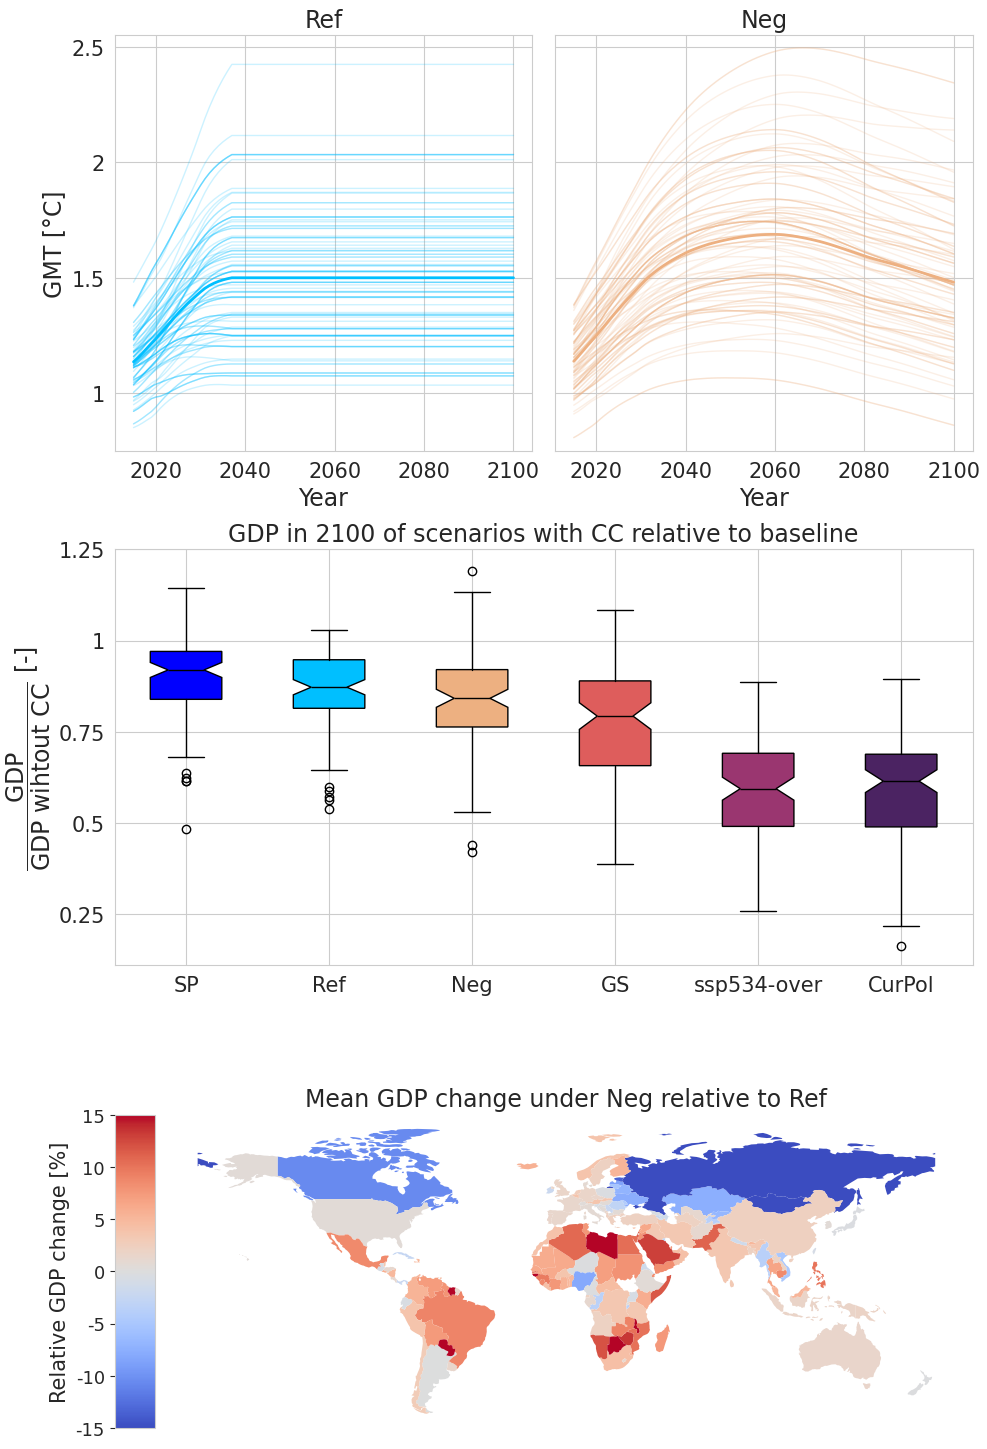

In [43]:
axes = []
with sns.axes_style('whitegrid'): 
        fig = plt.figure(figsize=(10, 15))
        gs  = GridSpec(3, 2, figure=fig)
    
        for i, scen in enumerate(['Ref', 'Neg']):
                ax = fig.add_subplot(gs[0, i])
                ax.plot(np.arange(2015,2101,1), 
                        gmt_ds.loc[:, gmt_ds.columns.str.contains(scen)].values,
                        color = scen_colors[i],
                        alpha = .2,
                        lw = 1)
                
                ax.plot(np.arange(2015,2101,1), 
                        gmt_ds.loc[:, gmt_ds.columns.str.contains(scen)].values.mean(axis = 1),
                        color = scen_colors[i],
                        lw = 2, zorder = 10)
                ax.set_xticks([2020, 2040, 2060, 2080, 2100],
                        ['2020', '2040', '2060', '2080', '2100'],
                        fontsize = labelsize_medium)
                ax.set_ylim(0.75,2.55)
                if i == 0:
                        ax.set_yticks([1,1.5,2,2.5],
                                [1,1.5,2,2.5], 
                                fontsize = labelsize_medium)
                        ax.set_ylabel('GMT [°C]', 
                                fontsize = labelsize_large)
                if i == 1: 
                        ax.set_yticks([1,1.5,2,2.5],
                                [],
                                fontsize = labelsize_medium)
                ax.set_title(scen, fontsize = labelsize_large)
                ax.set_xlabel('Year', fontsize = labelsize_large)            
                axes.append(ax)

        ax = fig.add_subplot(gs[1,:])
        bplot = ax.boxplot(boxplot_arr[:, :, 2].T, notch = True, 
                patch_artist = True)
        for patch, color in zip(bplot['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_edgecolor('black')
        for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
                plt.setp(bplot[element], color='black')
        ax.set_xticks(np.arange(1, 1+cset.n_focus_scenarios),
                        cset.focus_scenarios, 
                        fontsize=labelsize_medium)
        ax.set_yticks([0.25, 0.5, 0.75, 1, 1.25],
                        [0.25, 0.5, 0.75, 1, 1.25],
                        fontsize=labelsize_medium)
        ax.set_ylabel(r'$\dfrac{{\text{GDP}}}{{\text{GDP wihtout CC}}}$ [-]', 
                      fontsize=labelsize_large)   
        ax.set_title('GDP in 2100 of scenarios with CC relative to baseline', 
                     fontsize = labelsize_large)    
        axes.append(ax)
        
        ax = fig.add_subplot(gs[2,:])
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('left', size='5%', pad=0.05)

        cmap = plt.cm.get_cmap('coolwarm').copy()
        # cmap.set_extremes(under='yellow', over='orange')
        worldmap = world.plot(column = 'SSP_ref-neg', 
                   ax=ax, legend=True, 
                   cmap = cmap, 
                   cax=cax, 
                   vmin = -15, 
                   vmax = 15,)
        ax.set_axis_off()
        ax.set_title('Mean GDP change under Neg relative to Ref', 
                     fontsize = labelsize_large)
        cax.yaxis.tick_left()
        cax.yaxis.set_label_position("left")
        # cax.yaxis.set_extent([-10, 10])
        cax.set_yticks([-15, -10, -5, 0, 5, 10, 15],
                       [-15, -10, -5, 0, 5, 10, 15],
                       fontsize = labelsize_small)
        cax.set_ylabel('Relative GDP change [%]', 
                       fontsize = labelsize_medium)
        #cax.colorbar.extend = 'both'
        # cbar = fig.colorbar(worldmap.get_figure().axes[-1].collections[0], cax=cax, extend='both')
        # extended_ticks = True
        plt.tight_layout()
        
